In [112]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np



In [ ]:
os.getcwd()

## We want to have a dataframe with:
* X: rows = patients, cols = proteins filled with the protein quantity
* y: rows = patients, col  = health condition (healthy, cancer A, cancer B)

In [ ]:
path = r"data\tidy.csv"
tidy = pd.read_csv(path, sep=",")

tidy.head()

tidySub = tidy[["R.FileName", "uniprot", "meanAbu", "Group"]]

tidySub.head()

### To feed the data inot a model we need to reshape

In [ ]:
#reshape data
#X data
tidyReshaped = tidySub.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()
#y condition
Group =  tidySub.drop(["uniprot", "meanAbu"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()

#we merge to ensure that the y rows fit the corresponding x rows
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")

#to make df purely numerical
data = data.set_index("R.FileName")

X = data.iloc[:, :-1]
y = data.iloc[:,-1]

### Now that the data is prepared we continue with the following steps:
* Create pipeline for imputing, scaling !! **Scaling is not needed for Random Forest**
* (https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf)
* Creation of training, validation and test sets
* Feature Selection, Engineering
* Model Selection

In [ ]:
#Make pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X)

In [ ]:
# Encode target labels
from sklearn import preprocessing

labEnc = preprocessing.LabelEncoder() 

# apply label encoding
y = labEnc.fit_transform(y) 
print(y)

In [ ]:
# Feature Selection

"""
Can be used in pipeline
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel #checkout description https://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection

#create Random Forest classifier with default hyperparameters
raFo = RandomForestClassifier(n_estimators=100,  max_features="auto")
raFo = raFo.fit(X, y)

#checkout importance in a histogram
plt.hist(raFo.feature_importances_, bins=100)

#get the reduced X
model = SelectFromModel(estimator = raFo, prefit=True)
X_new = model.transform(X)
X_new.shape   

' plt.rcParams["figure.figsize"] = (10,5)\nplt.bar(raFo.feature_names, raFo.feature_importances_)\nplt.xlabel(\'Feature Labels\')\nplt.ylabel(\'Feature Importances\')\nplt.title(\'Comparison of different Feature Importances\'); '

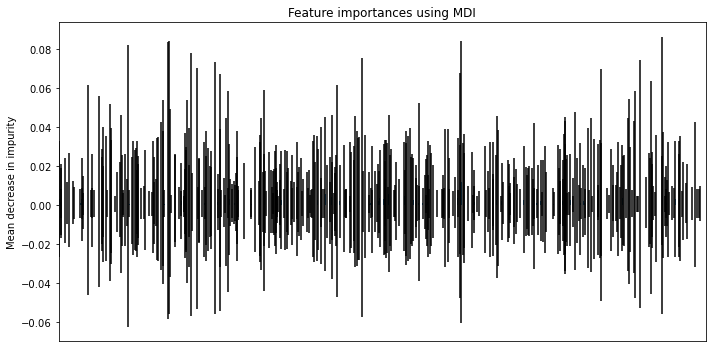

In [114]:
# Visualize feature importance

importances = raFo.feature_importances_
std = np.std([tree.feature_importances_ for tree in raFo.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.get_xaxis().set_visible(False)
fig.tight_layout()

""" plt.rcParams["figure.figsize"] = (10,5)
plt.bar(raFo.feature_names, raFo.feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances'); """

In [ ]:
#split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)